In [1]:
import pandas as pd
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_dataset(file_name):
    """     Purpose: To load the dataset
    
            Input: File name/Path
            Output: Data as Pandas Dataframe """
    
    return(pd.read_csv(file_name, low_memory=False))




def change_type_to_datetype(df, features):
    """     Purpose: To change the date columns in the dataset from string type to Date Type
    
            Input: Dataframe, The feature set to be converted
            Output: Updated Dataframe """
    
    new_df = df.copy()
    
    for each_feature in features:
        new_df[each_feature] = new_df[each_feature].apply(pd.to_datetime)
        
    return(new_df)

In [3]:
data = load_dataset("subscriptions.csv")

date_features = ["purchase_date","subscription_start_date", "subscription_end_date","cancellation_date" ,"user_created_date", "checkin_date"]
new_data = change_type_to_datetype(data, date_features)
#new_data.head()

# 1. Present the change and total user counts over time

In [4]:
def grp_date_and_count_distinct(df, grp_by_col, distinct_of_col, new_col_name):
    """     Purpose: To perform a group by a date column to count the distinct values in a column
    
            Input: Dataframe, group by column, column that needs a distinct count, new column name
            Output: Computed result Dataframe """
    
    new_df = df.copy()
    
    df = new_data.groupby([new_data[grp_by_col].dt.strftime('%Y %m')])[distinct_of_col].nunique().reset_index()
    df.columns=["year-month", new_col_name] 
    df = df.merge(df["year-month"].apply(lambda x: pd.Series({'Year':x[:4], 'Month': int(x[-2:])})), left_index=True, right_index=True)
    
    return(df[["Year", "Month", new_col_name]])




result_1 = grp_date_and_count_distinct(new_data, 'user_created_date', 'user_id', 'number_of_distinct_users')
print(result_1)

    Year  Month  number_of_distinct_users
0   2020      6                         4
1   2020      7                         4
2   2020      8                        41
3   2020      9                        31
4   2020     10                        37
5   2020     11                        61
6   2020     12                        36
7   2021      1                        78
8   2021      2                        66
9   2021      3                        74
10  2021      4                        92
11  2021      5                        89
12  2021      6                        92
13  2021      7                       175
14  2021      8                       347
15  2021      9                      3054
16  2021     10                      2955
17  2021     11                      3208


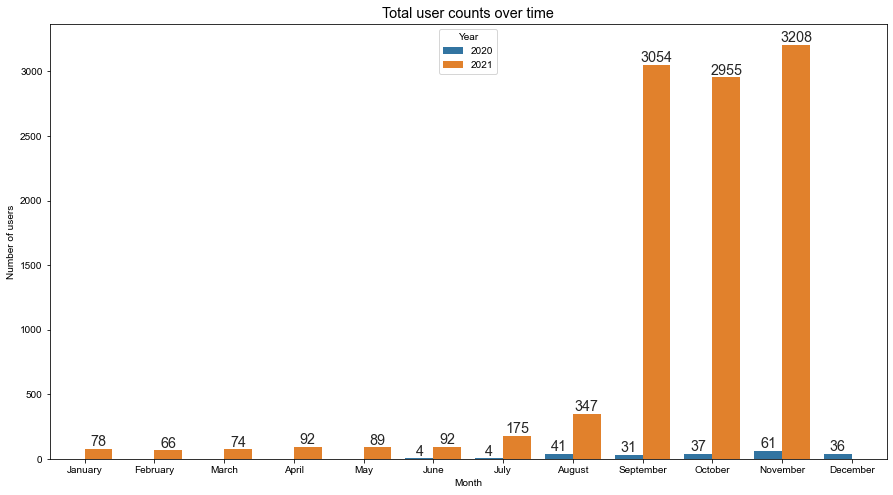

In [5]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(data = result_1, x="Month" , y="number_of_distinct_users", hue="Year")

labels = [calendar.month_name[i] for i in range(1, 13)]
ax.set_xticklabels(labels)
sns.set(font_scale = 1.2)
ax.set(xlabel='Month', ylabel='Number of users', title = "Total user counts over time")

for c in ax.containers:
    ax.bar_label(c)

### - From the dataset, one could analyse that the business model needed approximately 1 year(from Aug 2020 to Aug 2021), to attract more customers/users. It is also observed that the registration of new users has increased by 10 folds in September 2021. By Nov 2021, every month count of the average new customer registration is around 3000. 

# 2. Present the acquisition, churn and activity of users over time, with reference to %, deltas, and total counts.

In [6]:
def grp_date_and_sum(df, grp_by_col, distinct_of_col, new_col_name):
    """     Purpose: To perform a group by a date column to sum the values in a column
    
            Input: Dataframe, group by column, column that needs a summation, new column name
            Output: Computed result Dataframe """
    
    new_df = df.copy()
    
    df = new_data.groupby([new_data[grp_by_col].dt.strftime('%Y %m')])[distinct_of_col].sum().reset_index()
    df.columns=["year-month", new_col_name] 
    df = df.merge(df["year-month"].apply(lambda x: pd.Series({'Year':x[:4], 'Month': int(x[-2:])})), left_index=True, right_index=True)
    
    return(df[["Year", "Month", new_col_name]])




user_activity = grp_date_and_sum(new_data, 'user_created_date', 'lead_time_in_hours', 'hours_spent_by_users')
#print(user_activity)

user_churn = grp_date_and_count_distinct(new_data, 'cancellation_date', 'user_id', 'count_of_cancelled_subscribers')
#print(user_churn)

result_2 = reduce(lambda x,y: pd.merge(x,y, on=['Year', 'Month'], how='outer'), [result_1, user_activity, user_churn])
result_2["Month"] = result_2["Month"].apply(lambda x: calendar.month_name[x])
result_2

,Year,Month,number_of_distinct_users,hours_spent_by_users,count_of_cancelled_subscribers
0,2020,June,4.0,2689.0,NaN
1,2020,July,4.0,1253.0,NaN
2,2020,August,41.0,15377.0,NaN
3,2020,September,31.0,11670.0,NaN
4,2020,October,37.0,15144.0,NaN
5,2020,November,61.0,22022.0,NaN
6,2020,December,36.0,15684.0,NaN
7,2021,January,78.0,29956.0,NaN
8,2021,February,66.0,25348.0,NaN
9,2021,March,74.0,32803.0,NaN


In [7]:
print("Number of new users: ",result_2["number_of_distinct_users"].sum())
print("Number of users who cancelled subscription: ", result_2["count_of_cancelled_subscribers"].sum())


print("Churn Rate:", round(result_2["count_of_cancelled_subscribers"].sum()/ result_2["number_of_distinct_users"].sum() *100, 2), "%")

Number of new users:  10444.0
Number of users who cancelled subscription:  6431.0
Churn Rate: 61.58 %


In [8]:
avg = result_2["count_of_cancelled_subscribers"].sum()/ len(result_2[~result_2["count_of_cancelled_subscribers"].isna()])

print("Average churn per month: ", avg)

Average churn per month:  803.875


### - As the new customers increase over time, the time spent by them on the company website is also significantly increasing.
### - Although the churn rate seem to be as high as 62%, the numbers could be misleading because the average churn per month is around 800. Considering the new customer registration average count as 3000, the actual churn rate drops down to 26%.

# 3. Present the recurring revenue as it changes over time, with respect to cumulative, and absolute and relative changes over time

In [9]:
def get_cumulative_sum(series_data):
     return(series_data.cumsum())
    
def get_percent_change(series_data):
     return(series_data.pct_change() *100)


In [10]:
revenue_over_time = grp_date_and_sum(new_data, 'purchase_date', 'gross_price', 'total_absolute_revenue')

revenue_over_time['cumulative_revenue'] = get_cumulative_sum(revenue_over_time['total_absolute_revenue'])
revenue_over_time['relative_change_percent'] = get_percent_change(revenue_over_time['total_absolute_revenue'])
revenue_over_time["Month"] = revenue_over_time["Month"].apply(lambda x: calendar.month_name[x])

revenue_over_time

,Year,Month,total_absolute_revenue,cumulative_revenue,relative_change_percent
0,2021,September,100053.0,100053.0,NaN
1,2021,October,207246.0,307299.0,107.136218
2,2021,November,310327.5,617626.5,49.738716
3,2021,December,284185.0,901811.5,-8.424165
4,2022,January,245878.0,1147689.5,-13.479600
5,2022,February,200665.5,1348355.0,-18.388184
6,2022,March,180803.0,1529158.0,-9.898313
7,2022,April,50205.0,1579363.0,-72.232209


## 4. Considering monthly marketing costs outline and a fixed consultation cost of 20EUR represent profit, in a similar manner to above

In [11]:
def get_monthly_marketing_cost():
    m_data = load_dataset("marketing_spend.csv")
    
    return(m_data["monthly_total_spend"].sum())




def get_monthly_revenue(dataset, consultation_charge):
    df = dataset.copy()
    
    monthly_consultations_count = grp_date_and_sum(df, 'purchase_date', 'ask_your_doctor_count', 'total_monthly_consultations')
    monthly_consultations_count["revenue_20_euro_per_consult"] = monthly_consultations_count["total_monthly_consultations"] * consultation_charge
    monthly_consultations_count["Month"] = monthly_consultations_count["Month"].apply(lambda x: calendar.month_name[x])
    
    return(monthly_consultations_count)


In [12]:
fixed_consult_charge = 20

monthly_revenue_from_consultation = get_monthly_revenue(new_data, fixed_consult_charge)
monthly_total_marketing_cost = get_monthly_marketing_cost()

result_4 = pd.merge(revenue_over_time[["Year", "Month", "total_absolute_revenue"]], monthly_revenue_from_consultation,  how='inner')
result_4["total_income"] = result_4["total_absolute_revenue"] + result_4["revenue_20_euro_per_consult"]
result_4["profit"] = result_4["total_income"] - monthly_total_marketing_cost
result_4["profit_with_no_consultation_fee"] = result_4["total_absolute_revenue"] - monthly_total_marketing_cost

result_4

,Year,Month,total_absolute_revenue,total_monthly_consultations,revenue_20_euro_per_consult,total_income,profit,profit_with_no_consultation_fee
0,2021,September,100053.0,736.0,14720.0,114773.0,37618.0,22898.0
1,2021,October,207246.0,1249.0,24980.0,232226.0,155071.0,130091.0
2,2021,November,310327.5,1824.0,36480.0,346807.5,269652.5,233172.5
3,2021,December,284185.0,1036.0,20720.0,304905.0,227750.0,207030.0
4,2022,January,245878.0,845.0,16900.0,262778.0,185623.0,168723.0
5,2022,February,200665.5,488.0,9760.0,210425.5,133270.5,123510.5
6,2022,March,180803.0,285.0,5700.0,186503.0,109348.0,103648.0
7,2022,April,50205.0,23.0,460.0,50665.0,-26490.0,-26950.0


In [13]:
result_4[["Year", "Month", "profit"]]

,Year,Month,profit
0,2021,September,37618.0
1,2021,October,155071.0
2,2021,November,269652.5
3,2021,December,227750.0
4,2022,January,185623.0
5,2022,February,133270.5
6,2022,March,109348.0
7,2022,April,-26490.0


In [14]:
excl_april = result_4[~(result_4["Month"]=="April")]

print("Average monthly profit:", round(result_4["profit"].mean(),2))
print("Average monthly profit computed without considering April data:", round(excl_april["profit"].mean(),2))

Average monthly profit: 136480.38
Average monthly profit computed without considering April data: 159761.86


In [15]:
print("Average monthly profit(excluding consultation fee):", round(result_4["profit_with_no_consultation_fee"].mean(),2))
print("Average monthly profit computed(excluding april data and all consultation fee):", round(excl_april["profit_with_no_consultation_fee"].mean(),2))

Average monthly profit(excluding consultation fee): 120265.38
Average monthly profit computed(excluding april data and all consultation fee): 141296.14


In [16]:
(1 - (round(excl_april["profit_with_no_consultation_fee"].mean(),2)/  round(excl_april["profit"].mean(),2)))*100

11.558278052095773

### - Except for April 2022, the company is making a whooping profit of 130,000 on a monthly average. However, the April data seem to be incomplete. Hence, ignoring April 2022, the profit is around 160,000 per month. 

### - About 11% of the total profit earned by the company is generated from the consultation fee charged to the customer for doctor consultation.  

# 5. Consideration of churn

### How many users cancelled the subcription before the start date and how many during the subscription?

This question helps identify the cause of cancellation and take some measures to avoid cancellation:
- If the user cancelled before the subscription start date, the reason for cancellation could be some trust issues with the product/treatment.
- If the user cancelled during the subscription, may be the user is not satisfied with the treatment or the user could be concerned about the price etc., 

In any case, further investigations like below could be even interesting:
### What percentage of the subscription was used by the customer while cancelling the subscription? 

In [17]:
def get_churn_data(dataset):
    df = dataset.copy()
    
    return(df[~df["cancellation_date"].isna()])



churn_data = get_churn_data(new_data)
churn_data["days_cancellation"] = churn_data["subscription_end_date"] -churn_data["cancellation_date"] 

in_between = churn_data["cancellation_date"].between(churn_data.subscription_start_date, churn_data.subscription_end_date)
churn_data['status'] = np.where(in_between, 'Between', 'Before')

churn_data["status"].value_counts()

Between    6273
Before      173
Name: status, dtype: int64

In [18]:
cancelled_btw_subscription = churn_data[churn_data["status"]=="Between"]
cancelled_btw_subscription["days_to_end_sub"]= (cancelled_btw_subscription["subscription_end_date"] -cancelled_btw_subscription["cancellation_date"]).dt.days
cancelled_btw_subscription["interval_of_sub"] = (cancelled_btw_subscription["subscription_end_date"] - cancelled_btw_subscription["subscription_start_date"]).dt.days
cancelled_btw_subscription["percent_of_subscription_used"] = round((100 * cancelled_btw_subscription["days_to_end_sub"]) / cancelled_btw_subscription["interval_of_sub"], 2)

#cancelled_btw_subscription.head()

[Text(0.5, 0, 'Percentage of subcription used'),
 Text(0, 0.5, 'Number of users'),
 Text(0.5, 1.0, 'Percentage of subcription used by the customers when cancelling the subscription')]

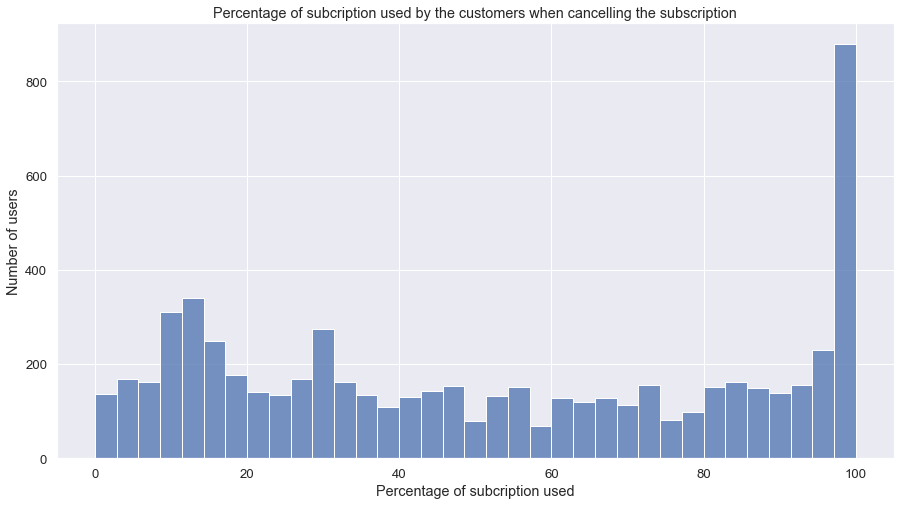

In [19]:
plt.figure(figsize=(15, 8))
ax = sns.histplot(cancelled_btw_subscription["percent_of_subscription_used"], bins = 35)
ax.set(xlabel='Percentage of subcription used', ylabel='Number of users', title = "Percentage of subcription used by the customers when cancelling the subscription")